# Imports

In [1]:
import time

import torch
import torch.nn as nn
from torch.nn import Sequential
from torch.optim import Adam
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

from src.constants import TRAIN_PATCHES_PATH, VALIDATION_PATCHES_PATH, MODEL_PATH
import matplotlib.pyplot as plt

from src.utils.helpers import check_if_dirs_exist

# Constants

In [2]:
from pathlib import Path

TRAIN_PATCHES_PATH = Path("../" + str(TRAIN_PATCHES_PATH))
VALIDATION_PATCHES_PATH = Path("../" + str(VALIDATION_PATCHES_PATH))
MODEL_PATH = Path("../" + str(MODEL_PATH))

INIT_LR = 1e-4
BATCH_SIZE = 64
EPOCHS = 10

# Initializations

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading

In [4]:
transform = transforms.Compose(
    [
        transforms.Grayscale(),  # Convert images to grayscale
        transforms.ToTensor(),  # Convert to tensor
    ]
)
trainImages = ImageFolder(TRAIN_PATCHES_PATH, transform=transform)
valImages = ImageFolder(VALIDATION_PATCHES_PATH, transform=transform)
trainDataLoader = DataLoader(trainImages, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valImages, batch_size=BATCH_SIZE)

print("[INFO] number of training images: {}".format(len(trainImages)))
print("[INFO] number of validation images: {}".format(len(valImages)))

[INFO] number of training images: 362740
[INFO] number of validation images: 16744


# Visualizing the data

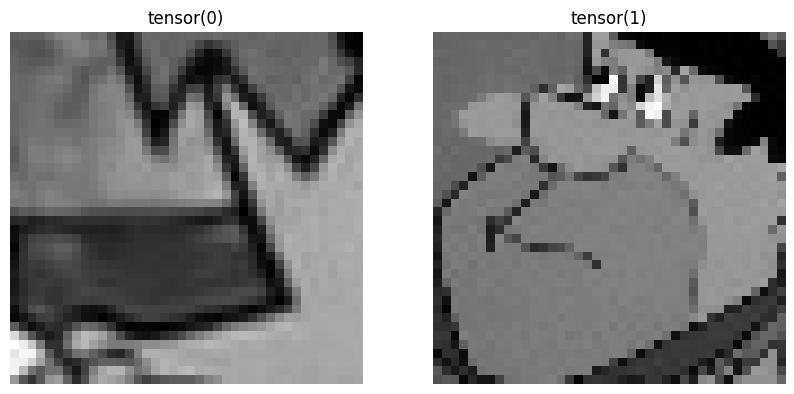

In [5]:
plot = plt.figure(figsize=(10, 10))
positive_found = False
negative_found = False

for x, y in trainDataLoader:
    for i in range(BATCH_SIZE):
        if y[i] == 0 and not negative_found:
            negative_found = True
            plot.add_subplot(1, 2, 1)
            plt.imshow(x[i].permute(1, 2, 0), cmap="gray")
            plt.title(y[i])
            plt.axis("off")
        elif y[i] == 1 and not positive_found:
            positive_found = True
            plot.add_subplot(1, 2, 2)
            plt.imshow(x[i].permute(1, 2, 0), cmap="gray")
            plt.title(y[i])
            plt.axis("off")
    break

# Model

In [6]:
model = Sequential(
    # Input: 1x40x40
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Dropout(0.25),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(256, 1),
    nn.Sigmoid(),
).to(device)

# Optimizer and loss function

In [7]:
optimizer = Adam(model.parameters(), lr=INIT_LR)
loss_function = nn.BCELoss()

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

# Training

In [8]:
print("[INFO] training the network...")
startTime = time.time()

for e in range(EPOCHS):
    model.train()
    totalTrainLoss = 0
    trainCorrect = 0

    for x, y in trainDataLoader:
        optimizer.zero_grad()
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        y = y.view(-1, 1).float()
        y = y.to(device)
        loss = loss_function(pred, y)
        loss.backward()
        optimizer.step()
        totalTrainLoss += loss.item()

        pred_binary = (pred > 0.5).float()
        trainCorrect += (pred_binary == y).sum().item()

    avgTrainLoss = totalTrainLoss / trainSteps
    trainAccuracy = trainCorrect / len(trainDataLoader.dataset)

    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainAccuracy))

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...
[INFO] EPOCH: 1/10
Train loss: 0.038845, Train accuracy: 0.9885
[INFO] EPOCH: 2/10
Train loss: 0.013290, Train accuracy: 0.9956
[INFO] EPOCH: 3/10
Train loss: 0.009887, Train accuracy: 0.9967
[INFO] EPOCH: 4/10
Train loss: 0.007477, Train accuracy: 0.9975
[INFO] EPOCH: 5/10
Train loss: 0.005870, Train accuracy: 0.9980
[INFO] EPOCH: 6/10
Train loss: 0.004736, Train accuracy: 0.9984
[INFO] EPOCH: 7/10
Train loss: 0.003773, Train accuracy: 0.9987
[INFO] EPOCH: 8/10
Train loss: 0.003299, Train accuracy: 0.9989
[INFO] EPOCH: 9/10
Train loss: 0.002693, Train accuracy: 0.9991
[INFO] EPOCH: 10/10
Train loss: 0.002494, Train accuracy: 0.9991
[INFO] total time taken to train the model: 831.97s


# Test the model on validation data

In [9]:
model.eval()
valCorrect = 0

with torch.no_grad():
    for x, y in valDataLoader:
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        y = y.view(-1, 1).float()
        pred_binary = (pred > 0.5).float()
        valCorrect += (pred_binary == y).sum().item()

valAccuracy = valCorrect / len(valDataLoader.dataset)

print("Validation accuracy: {:.4f}".format(valAccuracy))

Validation accuracy: 0.9990


# Saving the model

In [10]:
check_if_dirs_exist([MODEL_PATH])
model_scripted = torch.jit.script(model)
model_scripted.save(str(MODEL_PATH / "task1_cnn.pth"))